# PARAMETER IDENTIFICATION NOTEBOOK

In this notebook we leverage the pretrained surrogate models to identify the generating transmissivity fiels.\
We start from noisy signals. The noise is an additive white noise, manually added to the data to emulate experimental data. 

### Importing necessary libraries

In [2]:
# Standard library imports
import sys

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import arviz as az
import timeit
import scipy.stats as stats
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from itertools import product

#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal
from scipy.stats import uniform


# Local module imports
sys.path.append('../../')
sys.path.append('../../solver')
#sys.path.append('./src/InverseProblems')
#sys.path.append('./src/utils')
from utils import * 
from plotting import *
from random_process import *
from model import Model


### Decide sample to use for experimental data

In [3]:
sample = 13 # Which sample of the training set do wou want to take as experimental input?
OUTPUT_FILENAME = "./samples/sample_coarse_"+str(sample)

### Load data and select the sample 

In [ ]:
# Extract test data for visualization or further processing
n_eig = 64
X_values = np.loadtxt('../../data/50-25-10/X_test_50resolution.csv', delimiter = ',')
y_values = np.loadtxt('../../data/50-25-10/y_test_50resolution.csv',delimiter = ',')

# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]

### Load Surrogate Model

In [6]:
# Set the resolution of the model and the random field parameters.
resolution = (50, 50)
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl_fine = 64

model_fine = Model(resolution, field_mean, field_stdev, mkl_fine, lamb_cov)

# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))



def model_hf(x):
    model_fine.solve(x)
    return np.array(model_fine.get_data(datapoints)).reshape(25)


### Analysis with more complete diagnostics to investigate a particular scenario
Choose the wanted set of parameters to run this part and have more accurate diagnostics 

#### Define the Prior distribution and likelyhood 

In [7]:
# SET THE NOISE 
noise = 0.001

# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(64), cov = np.eye(64))

# Set the likelihood
cov_likelihood = noise * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)

In [18]:
y_true

array([0.99307968, 0.99051156, 0.96730411, 0.82081227, 0.81517549,
       0.83811262, 0.69193635, 0.66853686, 0.64877264, 0.63720504,
       0.60429379, 0.57300642, 0.5574177 , 0.59363314, 0.6060044 ,
       0.48536331, 0.51462396, 0.52306223, 0.53156518, 0.49560235,
       0.19104695, 0.05743577, 0.22160112, 0.2951756 , 0.16436559])

In [19]:
model_hf(x_true)

array([0.99307968, 0.99051156, 0.96730411, 0.82081227, 0.81517549,
       0.83811262, 0.69193635, 0.66853686, 0.64877264, 0.63720504,
       0.60429379, 0.57300642, 0.5574177 , 0.59363314, 0.6060044 ,
       0.48536331, 0.51462396, 0.52306223, 0.53156518, 0.49560235,
       0.19104695, 0.05743577, 0.22160112, 0.2951756 , 0.16436559])

#### Perform least square optimization for each starting point
Not needed we use as starting point np.zeros(64)

In [9]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

# Display the true parameters for reference
print("Real Params: ", x_true)

bounds = (-2.5*np.ones(64), 2.5*np.ones(64))

# Iterate over each parameter start point to perform optimizatio
# Perform least squares optimization given the observed data, forward model,
# start point, and parameter bounds
optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=model_hf , 
        start_point=np.zeros(64), #+  np.random.normal(scale=0.01,size=x_true.shape[0]), 
        bounds=bounds
    )

# Append the optimized parameters to the list of initial guesses
initial_guesses.append(optimized_params)

# Print the optimized parameters for this iteration
print(f"Optimized Params : {optimized_params}")


Real Params:  [ 1.1537516   1.59930096  1.0712466   0.16285143 -1.77693013  1.13429878
 -0.93495814  2.69019167  0.62724265  2.43673345 -0.56867574 -0.14274359
 -2.2278197  -0.75301225 -1.62102912  1.00922652  1.91294232 -0.85850774
 -2.31511961  2.52755889  0.09154126 -0.29053499 -0.53602897  0.34754535
 -0.01173919  1.17243121 -1.22188369 -0.96913818 -0.39950806  1.01188892
 -1.20621682 -0.87489908  0.57811353 -0.52530346 -1.09333604  1.10048611
  0.91836686  1.14180672  0.48037021  1.52078407  1.50176772  0.74254826
  0.04931592 -0.34914246  1.8694958   1.63233869 -1.17102144  1.14337158
  0.92133669  0.30800992 -0.87071644 -0.604474    0.22870254  0.15959755
  0.5696756  -0.17067527  0.27926433 -1.32688715  0.87618644  0.16703566
 -0.26100612  0.29748849  1.39345466 -0.99058778]
Optimized Params : [ 0.98119102  0.34000753  0.9223418   0.16835927 -1.51304182  1.45089557
 -1.59821186  1.65146361  1.53153118  1.27845748 -0.35904054 -0.09324511
 -2.25001738 -0.52229023 -0.75987372  0.5

#### Do Metropolis Hastings Sampling

Set the parameters for the algorithm 

In [10]:
scaling = 0.15
n_iter =  55000
burnin = 5000
thin = 50

In [11]:
#cov = np.diag(np.linspace(1,3,64))
cov = np.eye(64)

In [12]:
# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_hf)
# random walk Metropolis
#my_proposal = tda.GaussianRandomWalk(C=cov, scaling= scaling)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

In [13]:
# Initialize a list to hold the Markov chain samples for each initial guess
samples_mh = []
ESS_values = []

# Iterate over each initial guess to set up and run the Markov chain sampler
start_0 = timeit.default_timer() 
for index, initial_guess in enumerate(initial_guesses):
    samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
    idata = tda.to_inference_data(samples, level='fine')
    # Remove the burnin and sub-sample
    idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
    # Append the samples to the list
    samples_mh.append(idata)
    ess = az.ess(idata)
    # Compute and print the Effective Sample Size (ESS) of the first set of samples
    print("Effective Sample Size: ", ess,"\n\n\n")
end_0 = timeit.default_timer() 

# Computing diagnostics and collecting results
print("\nRhat: ", az.rhat(az.concat(samples_mh, dim = 'chain')))

#print('Mean ESS:' , np.mean(ESS_values, axis = 0))
#print('Time/ESS MDA',(end_0-start_0)/(5*np.mean(ESS_values, axis = 0)) )




Sampling chain 1/1


Running chain, α = 0.36: 100%|██████████| 55000/55000 [11:45<00:00, 77.91it/s] 
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1001), minimum_shape: (chains=2, draws=4)


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 69.69
    x1       float64 8B 106.1
    x2       float64 8B 107.1
    x3       float64 8B 121.6
    x4       float64 8B 76.8
    x5       float64 8B 109.2
    ...       ...
    x58      float64 8B 79.01
    x59      float64 8B 115.2
    x60      float64 8B 98.42
    x61      float64 8B 44.39
    x62      float64 8B 95.0
    x63      float64 8B 69.85 




Rhat:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B nan
    x1       float64 8B nan
    x2       float64 8B nan
    x3       float64 8B nan
    x4       float64 8B nan
    x5       float64 8B nan
    ...       ...
    x58      float64 8B nan
    x59      float64 8B nan
    x60      float64 8B nan
    x61      float64 8B nan
    x62      float64 8B nan
    x63      float64 8B nan


Let's look at the trace plot of one chain

#### Diagnostics 

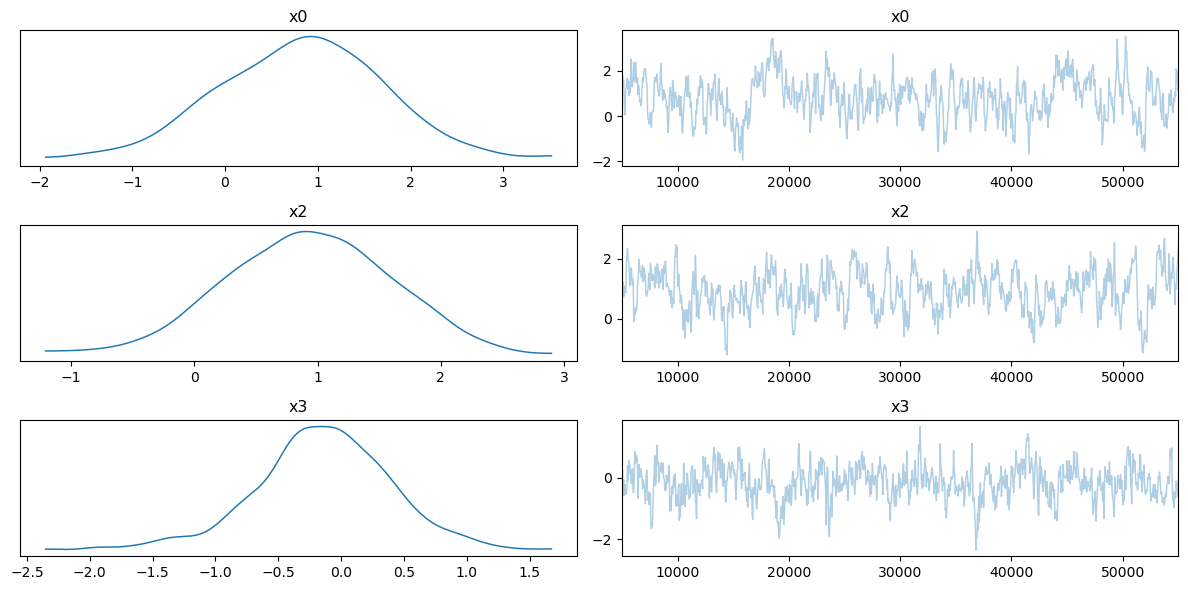

In [18]:
# Plot trace of the first set of samples
az.plot_trace(idata, var_names=['x0', 'x2', 'x3'])
plt.tight_layout()
plt.show()


Let's compare the prediction of the mean parameter combination and the experimental signal

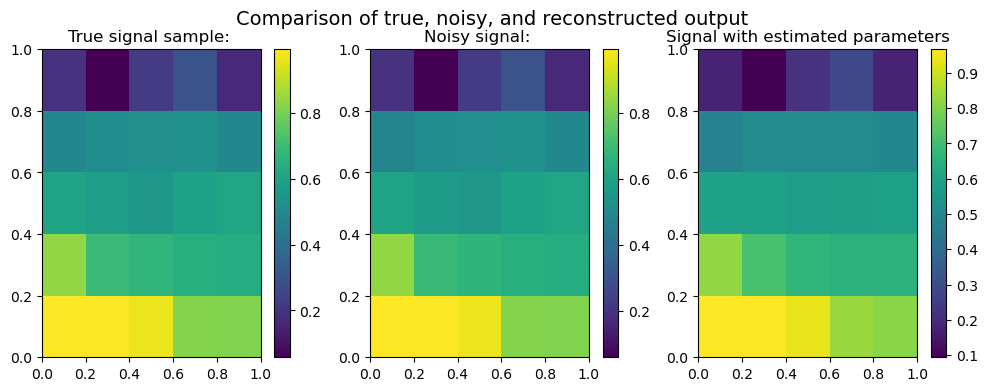

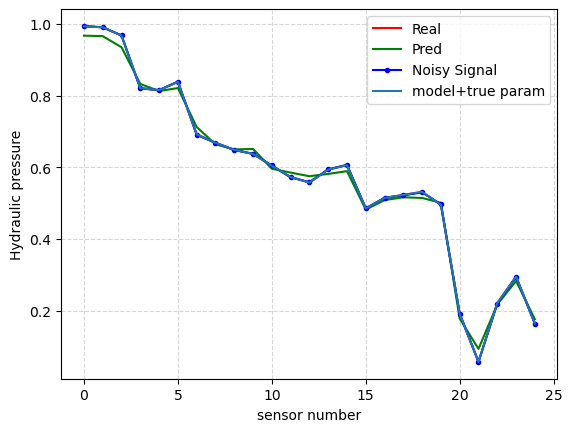

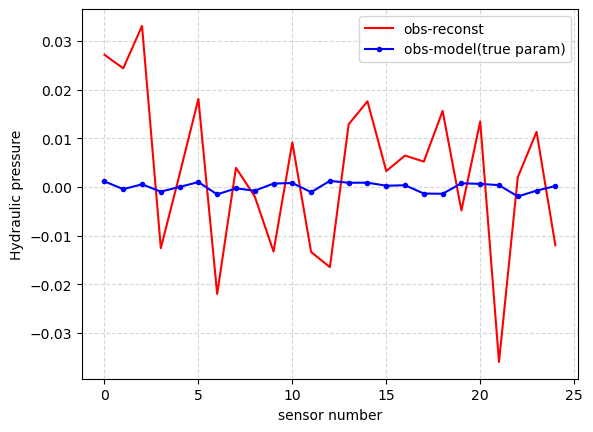

In [19]:
# Plotting and data collection
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_results( y_true, y_observed, model_hf, data, 64, x_true)

Finally, let's look at the parameters distribution

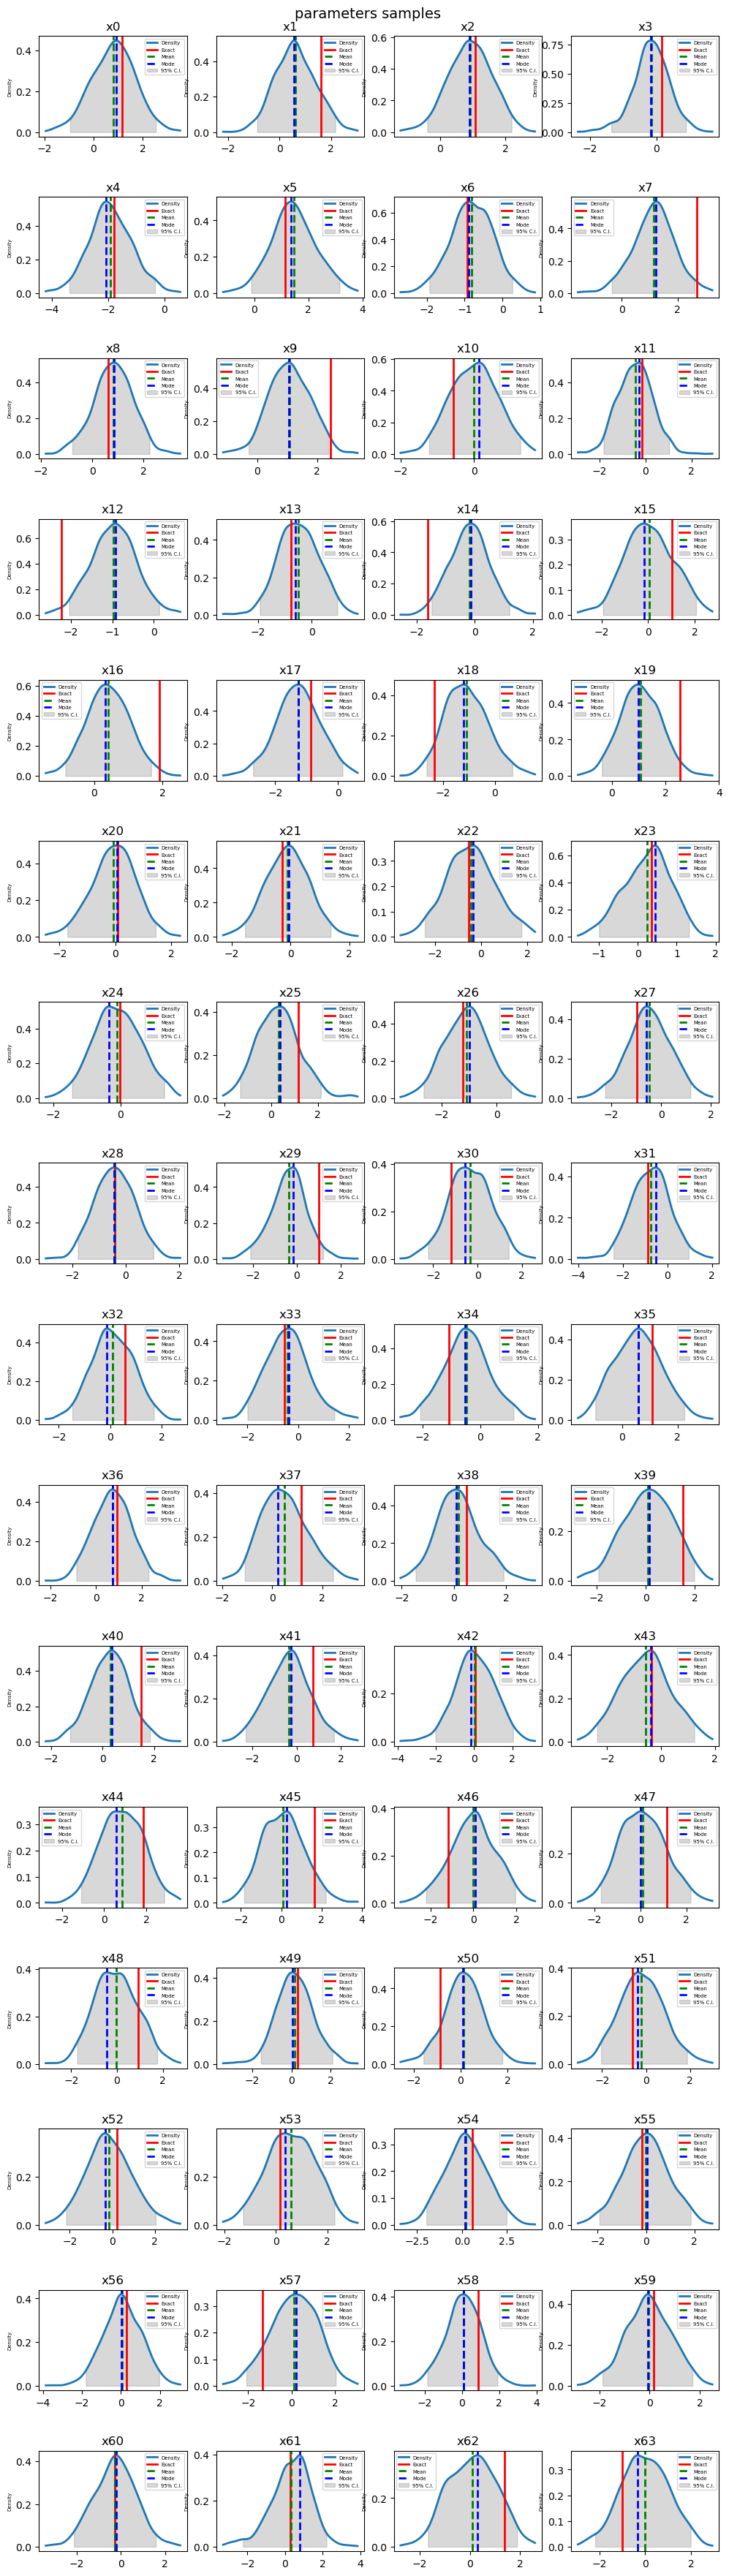

In [20]:
keys = ['x'+ str(i) for i in range(64)]
plot_parameter_distributions(data, x_true, keys, 64) 

#### Reconstructed field 

<Figure size 1000x400 with 0 Axes>

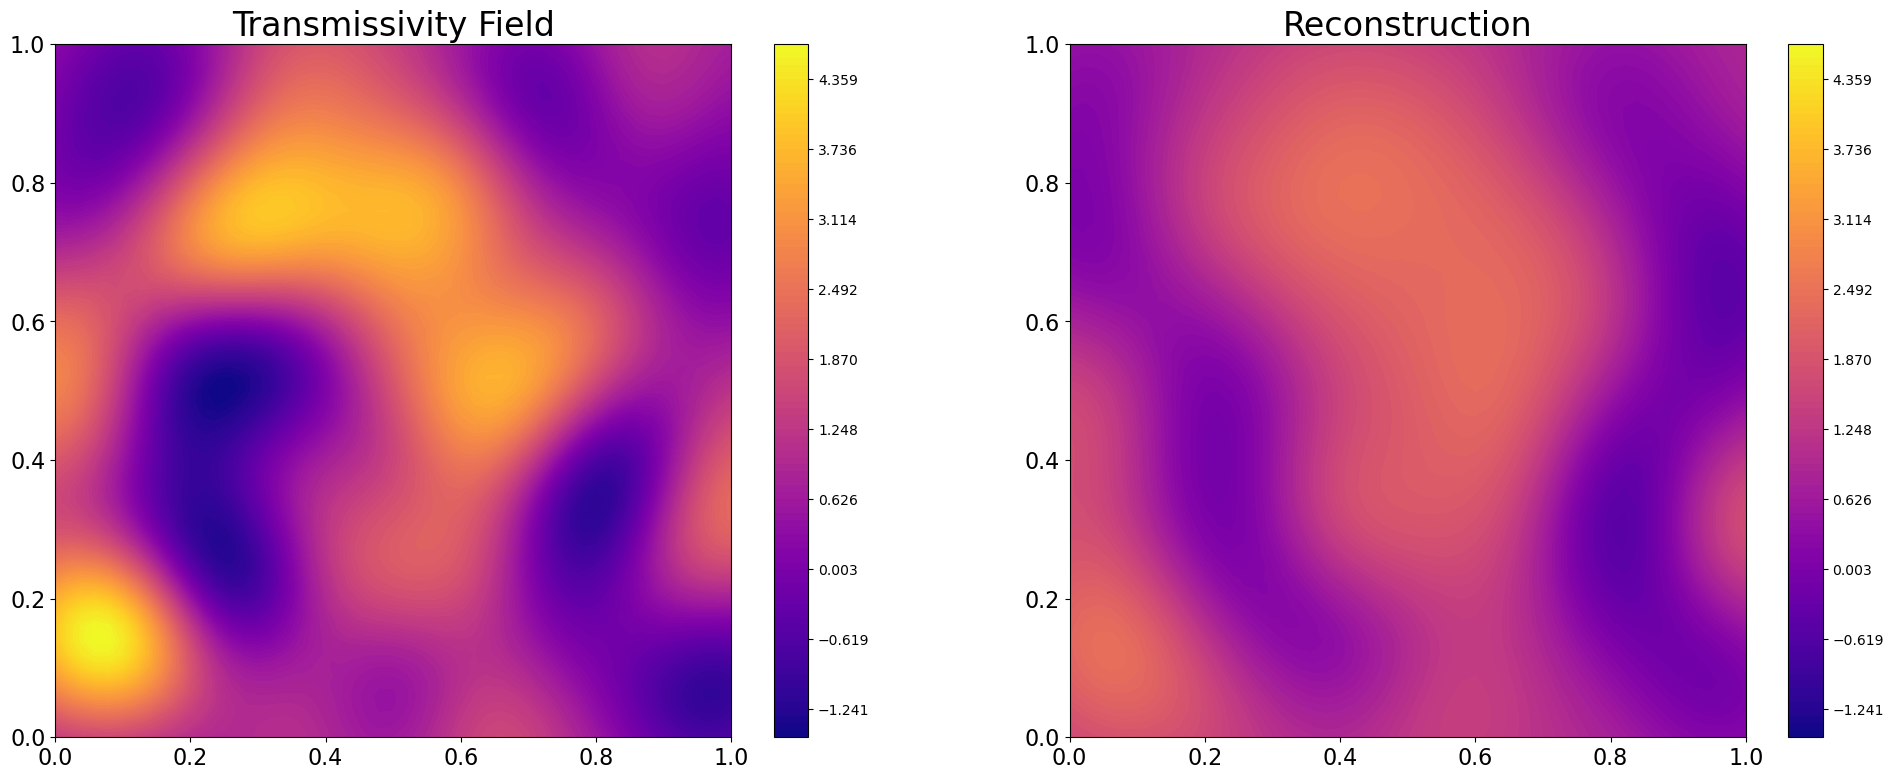

In [21]:
plot_fields(   x_true=x_true,
                x_estimated=data.mean(axis=0),
                n_eig=64,
                resolution=resolution,
                mean=field_mean,
                std_dev=field_stdev,
                lognormal=False)

# Different scenarios

### Likelyhood with multiplicative coefficient 

In [8]:
noise = 0.001
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(64), cov = np.eye(64))

# LIKELYHOOD
cov_likelihood = noise * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood*0.1)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_hf)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 0.31: 100%|██████████| 55000/55000 [13:34<00:00, 67.57it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 15.66
    x1       float64 8B 15.14
    x2       float64 8B 13.32
    x3       float64 8B 16.68
    x4       float64 8B 9.894
    x5       float64 8B 12.54
    ...       ...
    x58      float64 8B 4.137
    x59      float64 8B 2.924
    x60      float64 8B 6.523
    x61      float64 8B 16.06
    x62      float64 8B 4.532
    x63      float64 8B 19.3 





<Figure size 1000x400 with 0 Axes>

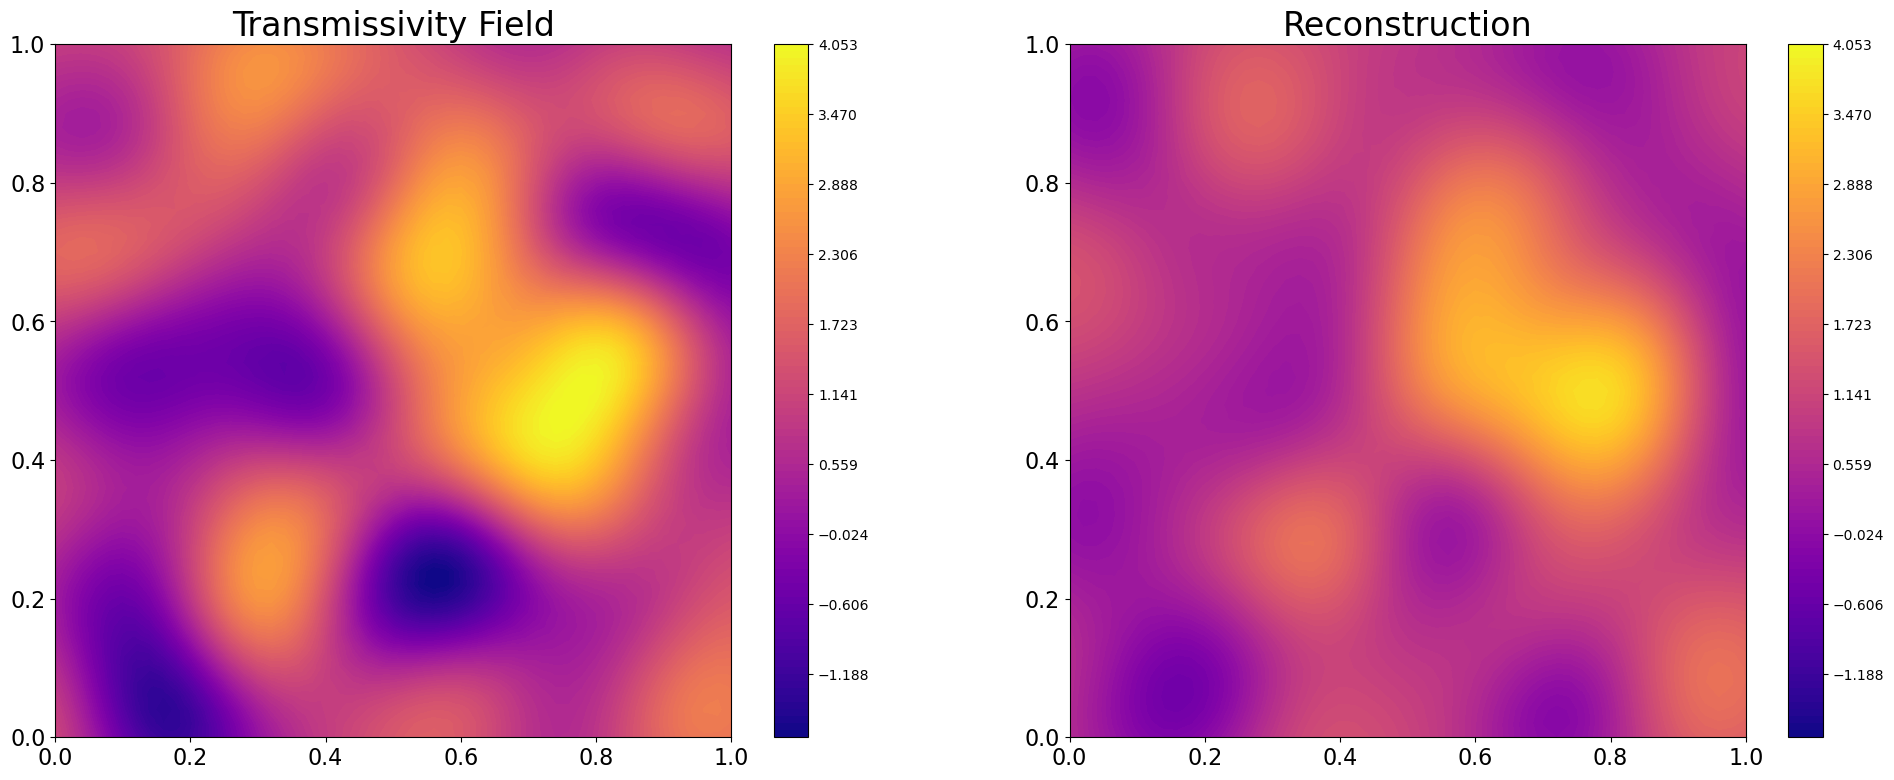

In [9]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :] 
plot_fields( x_true=x_true, x_estimated=data.mean(axis=0), n_eig=64, lognormal=False)

### Higher noise 

In [10]:
noise = 0.01
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(64), cov = np.eye(64))

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25) # noise to the power of 2 same coeff as reduced likelyhood
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_hf)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 1.00:   0%|          | 0/55000 [00:00<?, ?it/s]

Running chain, α = 0.30: 100%|██████████| 55000/55000 [14:11<00:00, 64.61it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 9.492
    x1       float64 8B 19.86
    x2       float64 8B 2.617
    x3       float64 8B 20.35
    x4       float64 8B 4.421
    x5       float64 8B 1.966
    ...       ...
    x58      float64 8B 7.447
    x59      float64 8B 15.6
    x60      float64 8B 5.334
    x61      float64 8B 17.3
    x62      float64 8B 7.215
    x63      float64 8B 11.34 





<Figure size 1000x400 with 0 Axes>

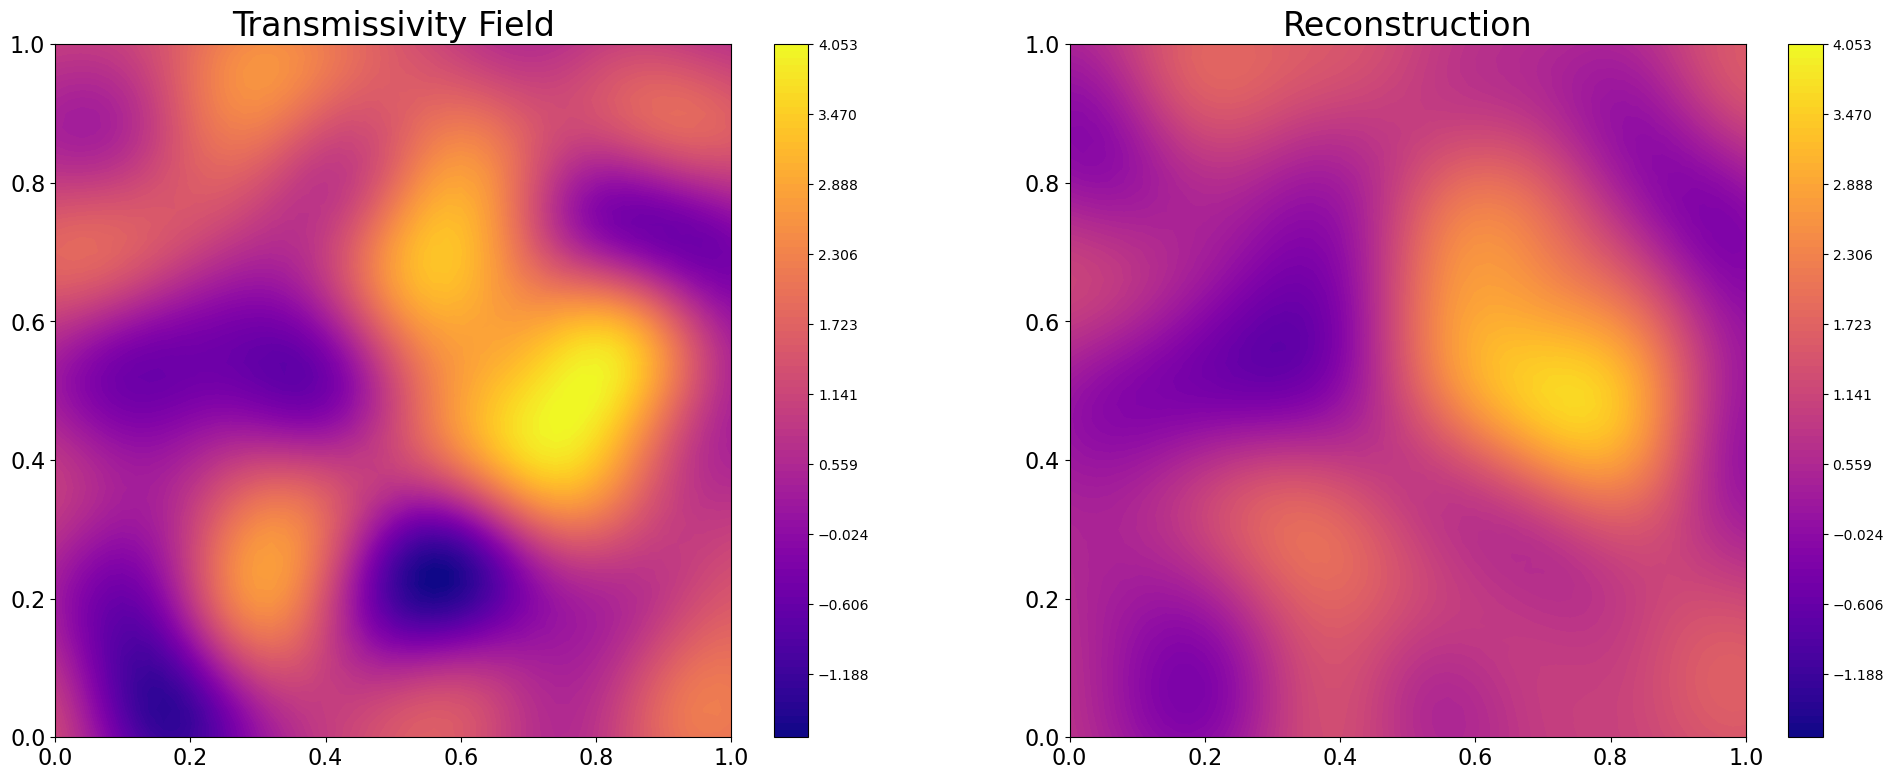

In [11]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields( x_true=x_true, x_estimated=data.mean(axis=0), n_eig=64, lognormal=False)

### No NOISE

In [18]:
noise = 0.0
scaling = 0.05
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(64), cov = np.eye(64))

# LIKELYHOOD
cov_likelihood = 0.01**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_hf)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 0.20: 100%|██████████| 55000/55000 [12:35<00:00, 72.84it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 9.364
    x1       float64 8B 11.82
    x2       float64 8B 5.477
    x3       float64 8B 22.99
    x4       float64 8B 15.06
    x5       float64 8B 32.2
    ...       ...
    x58      float64 8B 21.12
    x59      float64 8B 10.75
    x60      float64 8B 18.11
    x61      float64 8B 18.95
    x62      float64 8B 17.22
    x63      float64 8B 11.47 





<Figure size 1000x400 with 0 Axes>

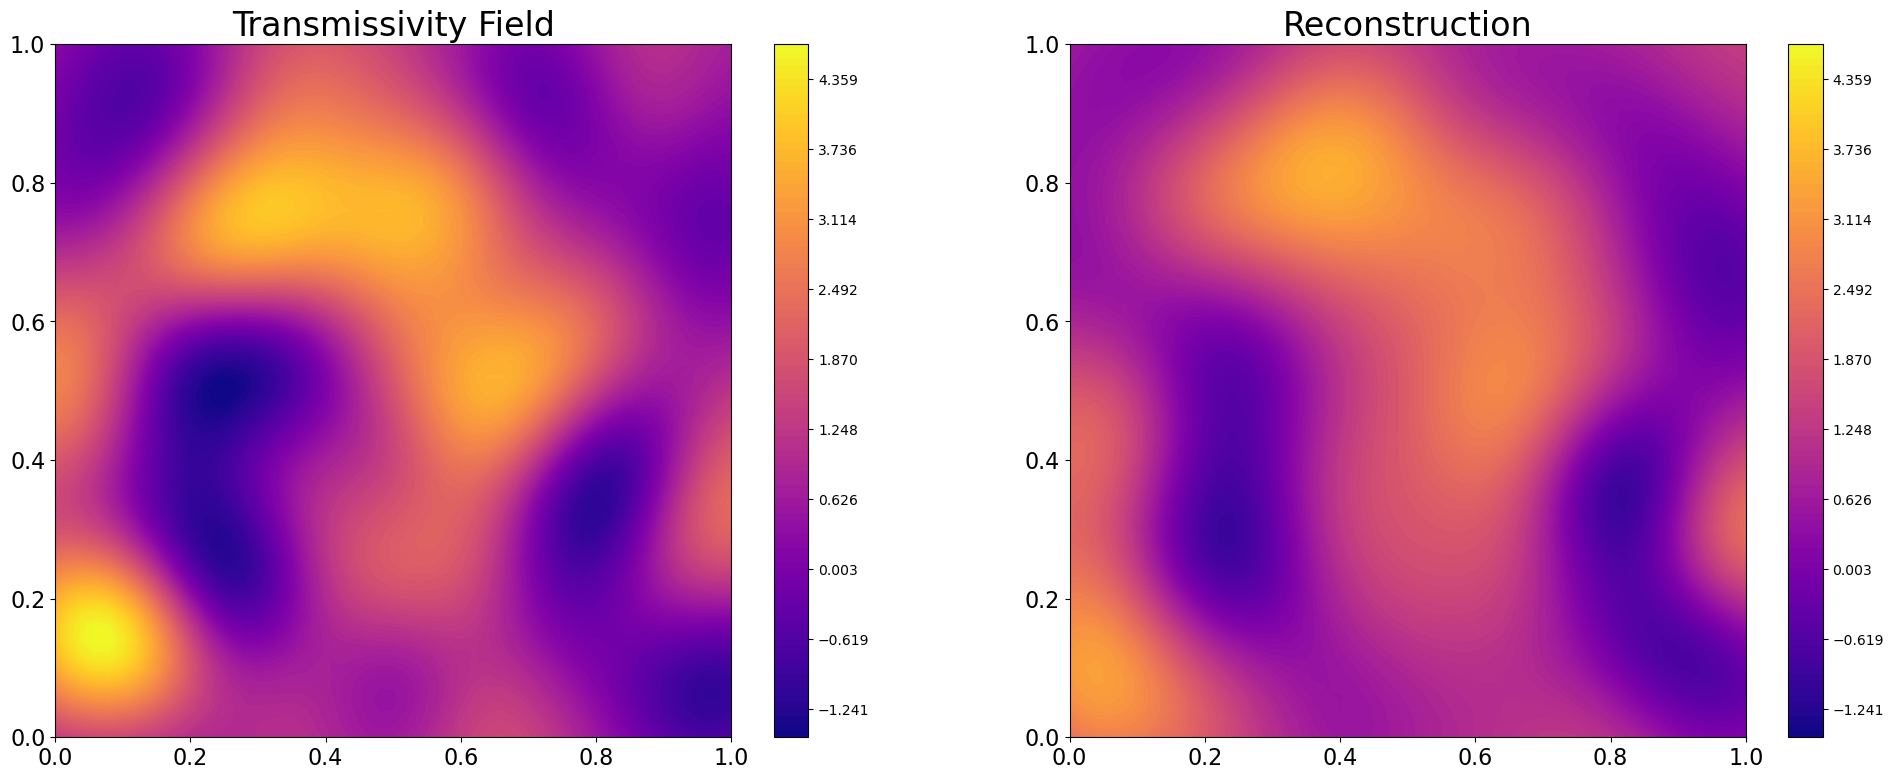

In [19]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields( x_true=x_true, x_estimated=data.mean(axis=0), n_eig=64, lognormal=False)

### True likelyhood

In [12]:
noise = 0.001
scaling = 0.0075
n_iter = 55000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# Define the prior distribution for the input parameters
x_distribution = stats.multivariate_normal(mean = np.zeros(64), cov = np.eye(64))

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_hf)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 1.00:   0%|          | 0/55000 [00:00<?, ?it/s]/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/tinyDA/proposal.py:340: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.likelihood - previous_link.likelihood)
Running chain, α = 0.11: 100%|██████████| 55000/55000 [13:24<00:00, 68.35it/s]
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 1.439
    x1       float64 8B 1.501
    x2       float64 8B 1.594
    x3       float64 8B 1.895
    x4       float64 8B 9.682
    x5       float64 8B 3.197
    ...       ...
    x58      float64 8B 1.352
    x59      float64 8B 13.94
    x60      float64 8B 3.336
    x61      float64 8B 1.615
    x62      float64 8B 10.85
    x63      float64 8B 1.316 





<Figure size 1000x400 with 0 Axes>

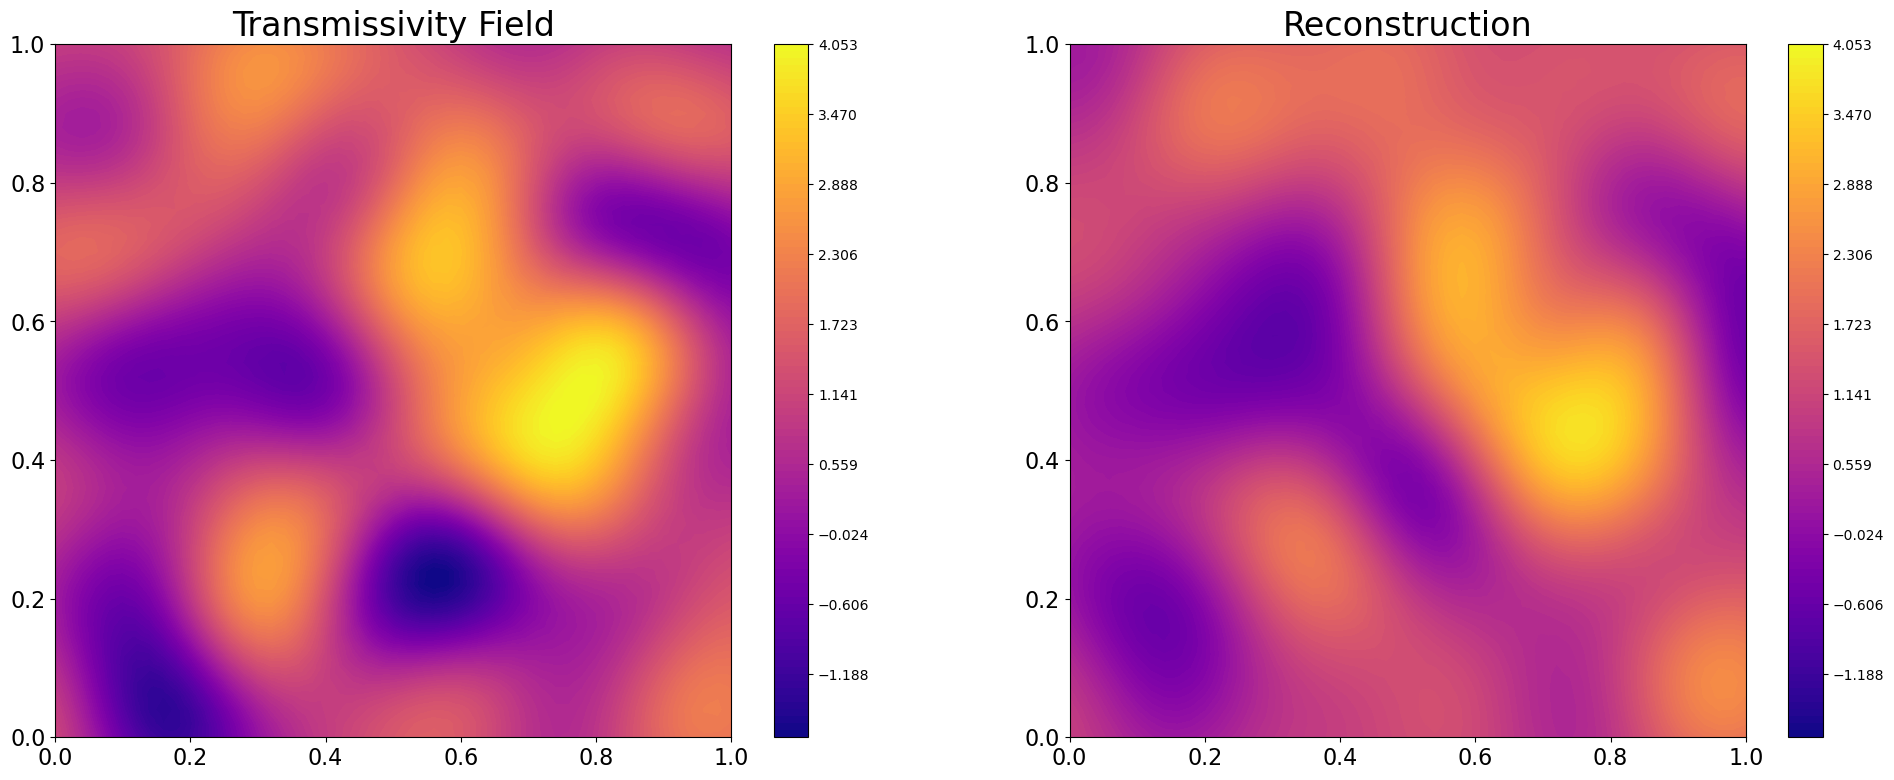

In [13]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields( x_true=x_true, x_estimated=data.mean(axis=0), n_eig=64, lognormal=False)

In [14]:
e = [ess.data_vars['x'+str(i)].values for i in range(64)]
np.mean(e)

4.192553814135234

In [30]:
713 / np.mean(e)

174.38016981558445

Low (real) likelyhood with more iterations 

In [8]:
noise = 0.001
scaling = 0.005
n_iter = 100000
burnin = 5000
thin = 50


y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0])

# LIKELYHOOD
cov_likelihood = noise**2 * np.eye(25)
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood)  

# initialise the LinkFactory
my_posterior = tda.Posterior(x_distribution, y_distribution, model_hf)
my_proposal = tda.CrankNicolson(scaling=scaling, adaptive=False, gamma = 1.01, period=100)

# RUN THE MCMC
samples = tda.sample(my_posterior, my_proposal, iterations=n_iter, n_chains=1, initial_parameters=np.zeros(64))
idata = tda.to_inference_data(samples, level='fine')
# Remove the burnin and sub-sample
idata = idata.sel(draw=slice(burnin, None, thin), groups="posterior")
ess = az.ess(idata)
# Compute and print the Effective Sample Size (ESS) of the first set of samples
print("Effective Sample Size: ", ess,"\n\n\n")

Sampling chain 1/1


Running chain, α = 0.60:   0%|          | 0/100000 [00:00<?, ?it/s]/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/tinyDA/proposal.py:340: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.likelihood - previous_link.likelihood)
Running chain, α = 0.20: 100%|██████████| 100000/100000 [21:06<00:00, 78.93it/s] 
/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


Effective Sample Size:  <xarray.Dataset> Size: 512B
Dimensions:  ()
Data variables: (12/64)
    x0       float64 8B 1.529
    x1       float64 8B 5.398
    x2       float64 8B 2.045
    x3       float64 8B 2.413
    x4       float64 8B 7.021
    x5       float64 8B 5.435
    ...       ...
    x58      float64 8B 4.987
    x59      float64 8B 1.346
    x60      float64 8B 1.682
    x61      float64 8B 15.24
    x62      float64 8B 7.531
    x63      float64 8B 1.347 





<Figure size 1000x400 with 0 Axes>

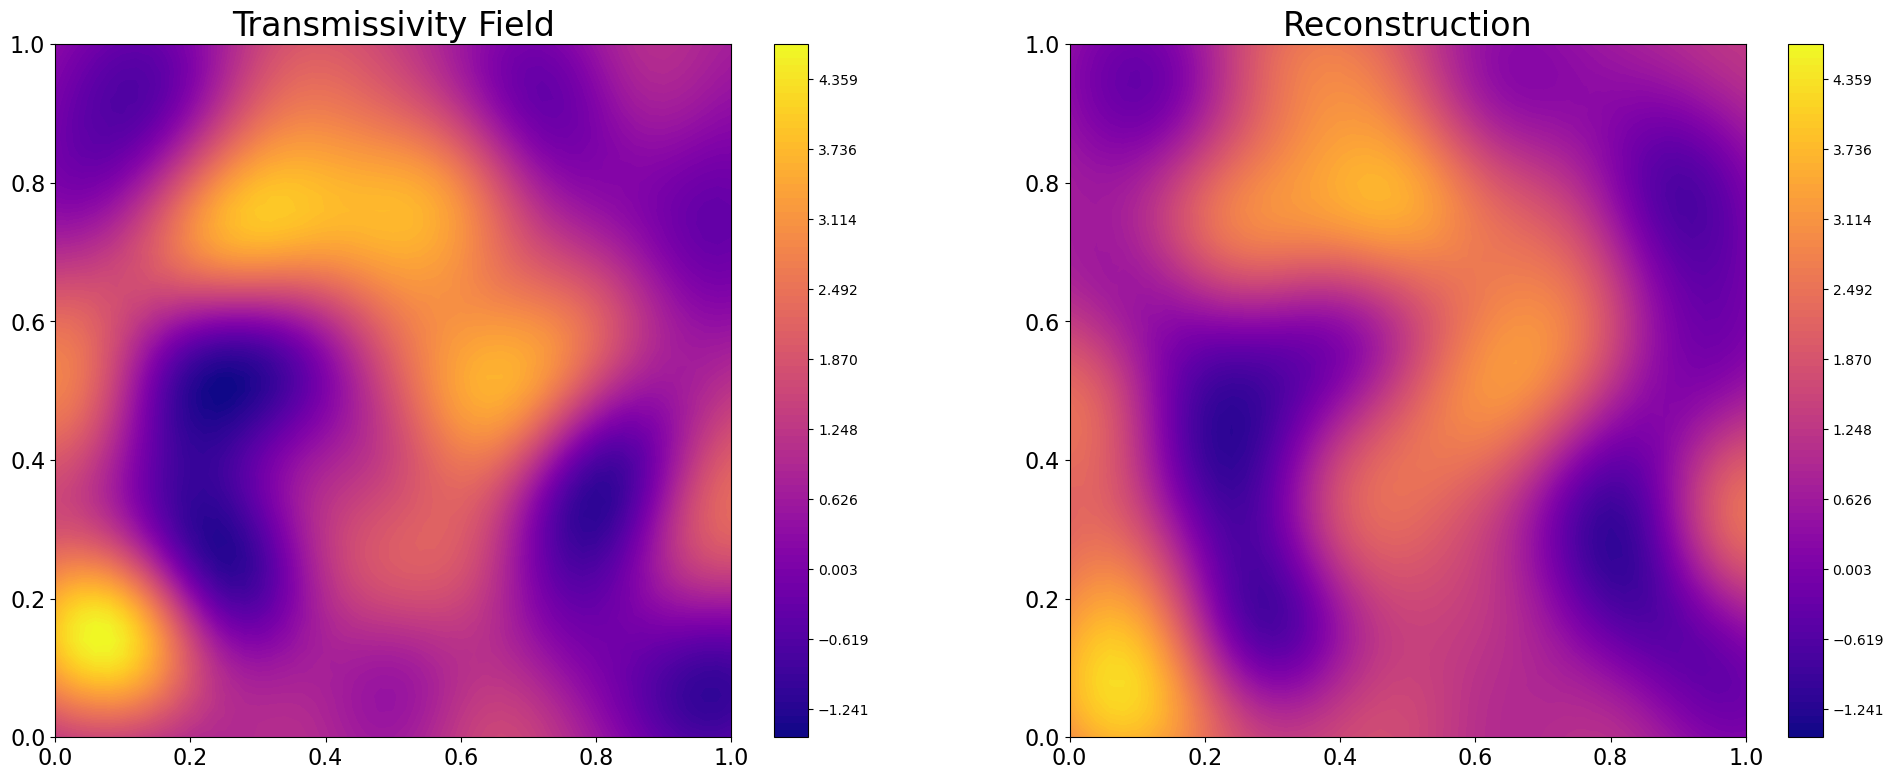

In [9]:
data = tda.get_samples(samples)['chain_0'][burnin:n_iter:thin, :]
plot_fields( x_true=x_true, x_estimated=data.mean(axis=0), n_eig=64, lognormal=False)